In [1]:
import collections as co
import pandas as pd
import numpy as np
import seaborn as sns
import re
from ete3 import PhyloTree, Tree, faces, AttrFace, CircleFace, TreeStyle, NodeStyle, TextFace, RectFace, SequenceFace
from scipy.cluster import hierarchy
from sklearn.preprocessing import normalize
import math
from matplotlib import colors
from natsort import natsorted
from Bio import SeqIO
from Bio.Seq import Seq
import scipy.spatial.distance as ssd

In [2]:
def roundup(x):
    return(int(math.ceil(int(x) / 10.0)) * 10)

In [3]:
def rounddown(x):
    return(int(math.floor(int(x) / 10.0)) * 10)

In [4]:
def getTimespan(year):
    
    try:
        down = rounddown(int(year))
        up = roundup(int(year))
        if down == up:
            timespan = f'{down}-{up+10}'
        else:
            timespan = f'{down}-{up}'
    except:
        timespan = 'NA'#np.nan
    
    return(timespan)

In [5]:
def getHostselection(host, hostdict):
    
    hostsel = ''
    for key in hostdict.keys():
        if re.match('(?:% s)' % '|'.join(hostdict[key]), host, re.IGNORECASE):
            hostsel = key
            break
    if not hostsel:
        hostsel = 'NA'
        #hostsel = host
    
    return(hostsel)

In [6]:
def getNewick(node, newick, parentdist, leaf_names):
    
    if node.is_leaf():
        return(leaf_names[node.id] + ":" + np.format_float_positional(parentdist - node.dist) + newick)
        #return "%s:%.5f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    
    else:
        if len(newick) > 0:
            newick = "):" + np.format_float_positional(parentdist - node.dist) + newick
            #newick = "):%.5f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), "," + newick, node.dist, leaf_names)
        #newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        
        newick = "(" + newick
        #newick = "(%s" % (newick)
        return(newick)

In [7]:
def getVector(frame, components, col):

    duplicate = components.copy()
    duplicate.update(frame[col].value_counts().to_dict())
    
    vector = pd.DataFrame([duplicate.values()])
    duplicate.clear()
    
    return(vector)

In [8]:
def getTree(framelink, treequery, feature = 'hostsel', rownumber = 2, segment = 4, prune = True, treshold = 0.5):
    
    treelabel = treequery.index.values
    treestyle = TreeStyle()
    treelink = framelink.drop(columns=['parent']).to_numpy()
    treehierarchy = hierarchy.to_tree(treelink, False)
    treenewick = getNewick(treehierarchy, "", treehierarchy.dist, treelabel)
    treedict = treequery[['cluster', feature]].to_dict()
    
    listfeature = natsorted(list(set(treedict[feature].values())))

    treecomponents = dict.fromkeys(listfeature, 0)
    featurevectors = treequery[['cluster', feature]].groupby(by=['cluster']).apply(lambda x: getVector(x, treecomponents, feature))
    featurevectors.reset_index(level = 1, drop = True, inplace=True)

    listcluster = featurevectors.index.tolist()
    featurel1vectors = normalize(featurevectors.to_numpy(), norm='l1')
    framefeature = pd.DataFrame(featurel1vectors, index = listcluster, columns = listfeature)

    tree = Tree(treenewick)
    
    listcolor = ['#FF0029','#377EB8','#66A61E','#984EA3','#00D2D5','#FF7F00',
                 '#AF8D00','#7F80CD','#B3E900','#C42E60','#A65628','#F781BF',
                 '#8DD3C7','#BEBADA','#FB8072','#80B1D3','#FDB462','#FCCDE5', 
                 '#99A893','#EED5D2','#3F00FF','#DABF86']
    
    if treshold != 0.0:
        listfeature.append('mixed')
    
    dictcolor = dict(zip(listfeature, listcolor[0:len(listfeature)]))
    prunecluster = []
    
    for node in tree.traverse():
        node.img_style["vt_line_width"] = 1
        node.img_style["hz_line_width"] = 1
        node.img_style["vt_line_type"] = 0
        node.img_style["hz_line_type"] = 0
        node.img_style["fgcolor"] = "#000000"
        node.img_style["shape"] = "circle"
        node.img_style["vt_line_color"] = "#000000"
        node.img_style["hz_line_color"] = "#000000"
        node.img_style['bgcolor'] = 'lightgrey'
    
    for leaf in tree.iter_leaves():
        leaf.feature = treedict[feature].get(leaf.name, "none")
        leaf.cluster = treedict['cluster'].get(leaf.name, "none")
    
    if -1 in listcluster:
        listcluster.remove(-1)
    
    for cluster in listcluster:
        listmember = tree.search_nodes(cluster=cluster)
        nodecluster = tree.get_common_ancestor(listmember)
        nodecluster.name = f'cluster {cluster}'
        nodecluster.size = len(listmember)
        
        frame = framefeature.loc[cluster].sort_values(axis=0, ascending=False)
        
        if treshold != 0.0:
            nodecluster.feature = (frame.idxmax() if frame.max() >= treshold else 'mixed')
        else:
            nodecluster.feature = frame.idxmax()
        
        nodecluster.add_face(AttrFace("name", fsize=10), 0, position="aligned")
        nodecluster.add_face(AttrFace("size", fsize=10, text_prefix='|', text_suffix='|'), 1, position="aligned") 
        nodecluster.img_style['bgcolor'] = dictcolor[nodecluster.feature]
        
        prunecluster.append(nodecluster.name)    
        
    if prune == True:
        tree.prune(prunecluster)
        
    treestyle =  TreeStyle()
    treestyle.show_leaf_name = False
    treestyle.draw_guiding_lines = True
    treestyle.guiding_lines_color = 'black'
    treestyle.mode = "c"
    treestyle.allow_face_overlap = False

    column = 0
    for i, feature in enumerate(listfeature, 1): 
        legendcolor = RectFace(width = 20, height = 20, fgcolor = "#000000", bgcolor = dictcolor[feature], label = None)
        treestyle.legend.add_face(legendcolor, column = column)
        legendtext = TextFace(feature)
        legendtext.margin_right = 5
        legendtext.margin_left = 1
        treestyle.legend.add_face(legendtext, column = column + 1)

        if i%rownumber == 0:
            column = column + 2

    treestyle.legend_position = 1
        
    return(tree, treestyle)

In [9]:
def subsplit(subtype):
    
    if re.match('^[H][0-9]+N[0-9]+$', subtype): 
        H = re.search('[H][0-9]+', subtype).group(0)
        N = re.search('[N][0-9]+', subtype).group(0)
    else:
        H = ''#np.nan
        N = ''#np.nan
    return(H, N)

In [10]:
def fillGaps(frame):
    
    arrayH = frame['H'].unique()
    arrayH = arrayH[arrayH != '']
    if len(arrayH) == 1:
        frame['H'].replace('', arrayH[0], inplace = True)
        frame['H'].fillna(arrayH[0], inplace = True)
    else:
        frame['H'].replace('', 'NA', inplace = True)
        frame['H'].fillna('NA', inplace = True)

    arrayN = frame['N'].unique()
    arrayN = arrayN[arrayN != '']
    if len(arrayN) == 1:
        frame['N'].replace('', arrayN[0], inplace = True)
        frame['N'].fillna(arrayN[0], inplace = True)
    else:
        frame['N'].replace('', 'NA', inplace = True)
        frame['N'].fillna('NA', inplace = True)
        
    return(frame)

In [11]:
hostdict =	{
    "human": [".*human.*"],
    "duck": [".*duck.*", ".*scaup.*", ".*pochard.*", ".*mallard.*", ".*bufflehead.*", ".*gadwall.*", ".*teal.*", ".*pintail.*", ".*shoveler.*", ".*wigeon.*", ".*pintail.*", ".*godwall.*", ".*goldeneye.*"],
    "bird": [".*murre.*", ".*crane.*", ".*hawk.*", ".*dove.*", ".*parrot.*", ".*dunlin.*", ".*owl.*", ".*shearwater.*", ".*bird.*", ".*grebe.*", ".*pheasant.*", ".*stint.*", ".*sparrow.*", ".*crow.*", ".*sandpiper.*", ".*falcon.*", ".*ostrich.*", ".*stork.*", ".*pigeon.*", ".*turkey.*", ".*sanderling.*", ".*knot.*", ".*quail.*", ".*waterfowl.*", ".*turnstone.*", ".*bird.*", ".*fowl.*", ".*avian.*"],
    "gull": [".*gull.*"],
    "chicken": [".*chicken.*"],
    "cat": [".*cat.*", ".*tiger.*"],
    "bat": [".*bat.*"],
    "swan": [".*swan.*"],
    "swine": [".*swine.*"],
    "equine": [".*equine.*"],
    "dog": [".*dog.*"],
    "goose": [".*goose.*"],
    "horse": [".*horse.*"],
    "environment": [".*environment.*"],
    "NA": [".*unknown.*"],
    "ferret": [".*mink.*", ".*ferret.*", ".*weasel.*"]
}

In [12]:
link = pd.read_csv('linkage.csv', sep = ',', na_filter = False, header = 0)
cluster = pd.read_csv('cluster.csv', sep = ',', na_filter = False, header = 0, index_col = 0)

In [13]:
exclude = [i for i, line in enumerate(open('A.fasta')) if not line.startswith('>')]
framemeta = pd.read_csv('A.fasta', skiprows = exclude, sep = '|', na_filter = False, header = None)
framemeta.columns = ['accession', 'strain', 'segment', 'protein', 'genus', 'subtype', 'date', 'host', 'curation', 'season', 'country', 'america']
#framemeta.columns = ['accession', 'strain', 'segment', 'protein', 'genus', 'subtype', 'date', 'host', 'curation']

In [14]:
framemeta['accession'] = framemeta['accession'].apply(lambda x: x.replace('>', ''))
framemeta[['month', 'day', 'year']] = framemeta['date'].apply(lambda x : x if len(re.findall('/', x)) == 2 else (x.split('/')[0] + '/NA/' + x.split('/')[1] if len(re.findall('/', x)) == 1 else 'NA/NA/' + x)).str.split('/', expand=True)
framemeta['year'] = framemeta['year'].apply(lambda x: x if not x.startswith('00') else '20' + x[2:])
framemeta[['H', 'N']] = framemeta['subtype'].apply(lambda x: subsplit(x)).tolist()
framemeta['timespan'] = framemeta['year'].apply(lambda x : getTimespan(x))
framemeta['hostsel'] = framemeta['host'].apply(lambda x : getHostselection(x, hostdict))

In [15]:
framemeta.set_index(keys = 'accession', inplace = True)

In [16]:
treequery = cluster.join(framemeta)
treequery[['H', 'N']] = treequery.groupby(by = ['cluster'])[['H', 'N']].apply(lambda x : fillGaps(x))
treequery.replace('', 'NA', inplace = True)

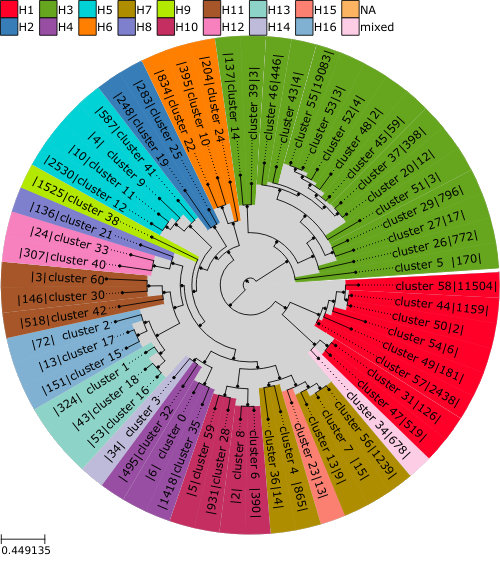

In [17]:
tree, ts = getTree(link, treequery, feature = 'H', rownumber = 2, segment = 4, prune = True, treshold = 1.0)
#tree, ts = getTree(link, treequery, feature = 'hostsel', rownumber = 3, segment = 4, prune = True, treshold = 0.9)
#tree, ts = getTree(link, treequery, feature = 'timespan', rownumber = 4, segment = 4, prune = True, treshold = 0.5)
#tree.render(file_name = '/home/ahenoch/Desktop/alpha0000_beta0000.pdf', tree_style = ts, w = 500)
tree.render(file_name = '%%inline', tree_style = ts, w = 500)